In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import numpy as np
from transformers import T5Tokenizer,T5ForConditionalGeneration, AdamW
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
import torchmetrics
import csv


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

In [2]:
df = pd.read_excel('../ArithOpsTrain.xlsx')
header = df.iloc[0][1:]
df = df.drop('Table 1',axis=1)
df = df[1:]
df.columns = header
df.head()

,Description,Question,Equation,Input Numbers,Output
1,gino has number0 popsicle sticks . i have numb...,what is the sum of our popsicle sticks ?,+ number0 number1,63 50,113
2,lino picked up number0 shells at the seashore ...,how many shells did he pick up in all ?,+ number0 number1,292 324,616
3,there were number0 parents in the program and ...,how many people were present in the program ?,+ number0 number1,105 698,803
4,last saturday marie sold number0 magazines and...,what is the total number of reading materials ...,+ number0 number1,425 275,700
5,there are number0 birds on the fence . number1...,how many birds are on the fence ?,+ number0 number1,12 8,20


percentile 90th is of length 239.0


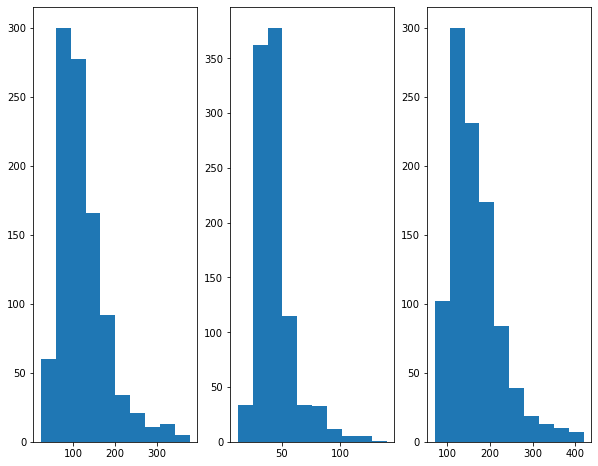

In [3]:
length_desc = df.Description.apply(lambda x:len(x))
length_q = df.Question.apply(lambda x:len(x))
length_overall = np.asarray(length_desc) + np.asarray(length_q)
perc_90 = np.quantile(length_overall,0.9)
print('percentile 90th is of length', perc_90)

plt.figure(figsize=(10,8))
plt.subplot(1,3,1)
plt.hist(length_desc)

plt.subplot(1,3,2)
plt.hist(length_q)

plt.subplot(1,3,3)
plt.hist(length_overall)
plt.show()

In [4]:
# X, val_df = train_test_split(df, test_size=0.15, random_state=123)
train_df, test_df = train_test_split(df, test_size=0.05, random_state=123)

train_df.shape, test_df.shape#, val_df.shape

((930, 5), (49, 5))

In [5]:
class ArithmeticDataset(Dataset):
    def __init__(
        self, 
        data: pd.DataFrame, 
        tokenizer: T5Tokenizer, 
        text_max_token_len: int = 512,
        eqn_max_token_len: int = 10
    ):
        self.tokenizer = tokenizer
        self.data = data
        self.text_max_token_len = text_max_token_len
        self.eqn_max_token_len = eqn_max_token_len

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx: int):
        data_row = self.data.iloc[idx]

        text = [data_row['Question'], data_row['Description']]
        eqn = data_row['Equation']

        text_encoding = self.tokenizer(
            text,
            max_length=self.text_max_token_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            add_special_tokens=True,
            return_tensors='pt')

        eqn_encoding = self.tokenizer(
            eqn,
            max_length=self.eqn_max_token_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            add_special_tokens=True,
            return_tensors='pt')
        
        labels = eqn_encoding['input_ids']
        labels[labels == 0] = -100
        
        return dict(
            text=text,
            eqn=eqn,
            text_input_ids=text_encoding['input_ids'].flatten(),
            text_attention_mask=text_encoding['attention_mask'].flatten(),
            labels=labels.flatten(),
            labels_attention_mask=eqn_encoding['attention_mask'].flatten()
        )



In [6]:
class ArithmeticDataModule(pl.LightningDataModule):
    def __init__(
        self,
        train_df: pd.DataFrame,
        test_df: pd.DataFrame,
        tokenizer: T5Tokenizer,
        batch_size: int = 8,
        text_max_token_len: int = 512,
        eqn_max_token_len: int = 10
        ):

        super().__init__()

        self.train_df = train_df
        self.test_df = test_df

        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.text_max_token_len = text_max_token_len
        self.eqn_max_token_len = eqn_max_token_len
    
    def setup(self, stage=None):
        self.train_dataset = ArithmeticDataset(
            self.train_df,
            self.tokenizer,
            self.text_max_token_len,
            self.eqn_max_token_len
        )

        self.test_dataset = ArithmeticDataset(
            self.test_df,
            self.tokenizer,
            self.text_max_token_len,
            self.eqn_max_token_len
        )
    
    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=2
        )
    
    def val_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=2
        )
    
    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=2
        )


In [7]:
MODEL_NAME = 't5-base'

tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)

additional_tkns = ['number0','number1','number2']

tokenizer.add_tokens(additional_tkns,special_tokens=True)

/raid/home/ankitsingh1/anaconda3/lib/python3.9/site-packages/transformers/models/t5/tokenization_t5.py:164: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


3

In [8]:
N_EPOCHS = 10
BATCH_SIZE = 8

data_module = ArithmeticDataModule(train_df, test_df, tokenizer, batch_size=BATCH_SIZE)

# MODEL

In [9]:
class ArithmeticModel(pl.LightningModule):

    def __init__(self):
        super().__init__()
        self.model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME, return_dict=True)
        self.accuracy = torchmetrics.Accuracy()
    
    def forward(self, input_ids, attention_mask, decoder_attention_mask, labels=None):

        output = self.model(
            input_ids,
            attention_mask=attention_mask,
            labels=labels,
            decoder_attention_mask=decoder_attention_mask
        )
        
        return output.loss, output.logits
    
    def training_step(self, batch, batch_idx):
        input_ids = batch['text_input_ids']
        attention_mask = batch['text_attention_mask']
        labels = batch['labels']
        labels_attention_mask = batch['labels_attention_mask']

        loss, output = self(
            input_ids=input_ids, 
            attention_mask=attention_mask,
            decoder_attention_mask=labels_attention_mask,
            labels=labels
            )
        
        self.log('train_loss', loss, prog_bar=True, logger=True)

        return loss
    
    def validation_step(self, batch, batch_idx):
        input_ids = batch['text_input_ids']
        attention_mask = batch['text_attention_mask']
        labels = batch['labels']
        labels_attention_mask = batch['labels_attention_mask']

        loss, output = self(
            input_ids=input_ids, 
            attention_mask=attention_mask,
            decoder_attention_mask=labels_attention_mask,
            labels=labels
            )
        
        # actual_op = labels
        # pred_op = output
        # acc = (labels == output).sum()/labels.shape[0]
        # print(output)
        # self.accuracy(output, labels)
        
        self.log('val_loss', loss, prog_bar=True, logger=True)
        # self.log('val_acc', output, prog_bar=True, logger=True)

        return loss
    
    def test_step(self, batch, batch_idx):
        input_ids = batch['text_input_ids']
        attention_mask = batch['text_attention_mask']
        labels = batch['labels']
        labels_attention_mask = batch['labels_attention_mask']

        loss, output = self(
            input_ids=input_ids, 
            attention_mask=attention_mask,
            decoder_attention_mask=labels_attention_mask,
            labels=labels
            )
        
        self.log('test_loss', loss, prog_bar=True, logger=True)

        return loss
    
    def configure_optimizers(self):
        return AdamW(self.parameters(), lr=1e-4)

In [10]:
model = ArithmeticModel()

In [11]:
%load_ext tensorboard
%tensorboard  --logdir ./lightning_logs

In [12]:
checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints",
    filename="best_checkpoint",
    save_top_k=1,
    verbose=True,
    monitor='val_loss',
    mode='min'
)

logger = TensorBoardLogger('lightning_logs', name='Arithmetic-eqn')

trainer = pl.Trainer(
    logger=logger,
    callbacks=[checkpoint_callback],
    max_epochs=N_EPOCHS,
    accelerator='gpu',
    devices=[2],
    enable_progress_bar=True
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [13]:
trainer.fit(model, data_module)

Missing logger folder: lightning_logs/Arithmetic-eqn
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/raid/home/ankitsingh1/anaconda3/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

  | Name     | Type                       | Params
--------------------------------------------------------
0 | model    | T5ForConditionalGeneration | 222 M 
1 | accuracy | Accuracy                   | 0     
--------------------------------------------------------
222 M     Trainable params
0         Non-trainable params
222 M     Total params
891.614   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/raid/home/ankitsingh1/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 40 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/raid/home/ankitsingh1/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 40 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 0, global step 117: 'val_loss' reached 2.77776 (best 2.77776), saving model to '/raid/home/ankitsingh1/DLNLP/Assign5/checkpoints/best_checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 234: 'val_loss' reached 2.44440 (best 2.44440), saving model to '/raid/home/ankitsingh1/DLNLP/Assign5/checkpoints/best_checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 2, global step 351: 'val_loss' reached 1.86172 (best 1.86172), saving model to '/raid/home/ankitsingh1/DLNLP/Assign5/checkpoints/best_checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 3, global step 468: 'val_loss' reached 1.61169 (best 1.61169), saving model to '/raid/home/ankitsingh1/DLNLP/Assign5/checkpoints/best_checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 4, global step 585: 'val_loss' reached 1.30163 (best 1.30163), saving model to '/raid/home/ankitsingh1/DLNLP/Assign5/checkpoints/best_checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 5, global step 702: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 6, global step 819: 'val_loss' reached 1.18170 (best 1.18170), saving model to '/raid/home/ankitsingh1/DLNLP/Assign5/checkpoints/best_checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 7, global step 936: 'val_loss' reached 1.09358 (best 1.09358), saving model to '/raid/home/ankitsingh1/DLNLP/Assign5/checkpoints/best_checkpoint.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 8, global step 1053: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 9, global step 1170: 'val_loss' reached 0.92988 (best 0.92988), saving model to '/raid/home/ankitsingh1/DLNLP/Assign5/checkpoints/best_checkpoint.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=10` reached.


In [14]:
trained_model = ArithmeticModel.load_from_checkpoint(
    trainer.checkpoint_callback.best_model_path
)

trained_model.freeze()


In [15]:
def compute_eqn(text_question, text_description):
    text_encoding = tokenizer(
        text_question,
        text_description,
        max_length=396,
        padding='max_length',
        truncation="only_second",
        return_attention_mask=True,
        add_special_tokens=True,
        return_tensors='pt'
    )
    
    generated_ids = trained_model.model.generate(
        input_ids=text_encoding['input_ids'],
        attention_mask=text_encoding['attention_mask'],
        max_length=10,
        num_beams=1,
        repetition_penalty=2.5,
        length_penalty=1.0,
        early_stopping=True,
        use_cache=True
    )
    
    preds = [
        tokenizer.decode(gen_id, skip_special_tokens=True, clean_up_tokenization_spaces=True)
        for gen_id in generated_ids
    ]
    
    return "".join(preds)

In [16]:
# sample_row = test_df.iloc[0]

# eqn = sample_row['Equation']

eqn_preds = compute_eqn('how many apples are in the basket ?', 'number0 red apples and number1 green apples are in the basket .')

In [17]:
eqn_preds

'+ number0 number1'

In [19]:
dict_num = {'number0':0, 'number1':1, 'number2':2,'number3':3,'number4':4,'number5':5,'number6':6,'number7':7,'number8':8,
            'number9':9}
def replace_with_numbers(eqn, nums):
    nums = nums.split()
    # new_eqn = eqn
    for tok in eqn.split():
        if tok in dict_num.keys():
            # print(tok, nums[dict_num[tok]])
            try:
                eqn = eqn.replace(tok, nums[dict_num[tok]])
            except:
                print(dict_num, tok, nums)
                continue
    eqn = eqn.strip()
    return eqn
    

In [20]:
replace_with_numbers('+ number0 number1','7 2')

'+ 7 2'

In [21]:
# Python3 program to evaluate a prefix expression.
def isdigit(ch):
    for i in ch:
        if(ord(i) < 48 or ord(i) > 57) and i !='.':
            return False
    return True
  
def evaluatePrefix(expr):
    try:
        S = []
        expr = expr.split()[::-1]
        # print(expr)
        for i in expr:
            # print(i)
            if isdigit(i):
                S.append(float(i))
            else:
                a = S.pop()
                b = S.pop()
                if i == '+':
                    S.append(a+b)
                elif i == '-':
                    S.append(a-b)
                elif i == '*':
                    S.append(a*b)
                elif i == '/':
                    S.append(a/b)
            # print(S, i)
        return S[-1]
    
    except :
        return np.nan
            

In [22]:
evaluatePrefix('+ 7 2')

9.0

In [23]:
def compute_on_test_data(x):
    
    pred_eqns = compute_eqn(x['Question'], x['Description'])
    
    final_eqn = replace_with_numbers(pred_eqns, x['Input Numbers'])
    
    ans = evaluatePrefix(final_eqn)
    
    if ans == int(ans):
        return int(ans)
    else:
        return np.around(ans, decimals=2)
    
    # test_df['pred_eqns'] = test_df.apply(lambda x: compute_eqn(x['Question'], x['Description']), axis=1)
    
    # test_df['final_eqn'] = test_df.apply(lambda x: replace_with_numbers(x['pred_eqns'], x['Input Numbers']), axis=1)
    
    # test_df['output_final'] = test_df.final_eqn.apply(lambda x: evaluatePrefix(x))
    
    # return ans if ans - int(ans) else int(ans)

# FINAL CODE

In [24]:
def predict(test_df, save=False):
    test_df = test_df.apply(lambda x:compute_on_test_data(x), axis=1).to_numpy()
    test_df = [[int(i)] if  i == int(i) else [np.around(i,decimals=2)] for i in test_df]
    if save:
        with open("abcd.csv","a") as f:
            writer = csv.writer(f)
            for row in test_df:
                writer.writerow(row)
    return test_df
    # test_df['output_pred'].to_csv('abc.csv',index=False)


In [25]:
sample_df = test_df.copy()
pred_y = predict(sample_df, save=True)
pred_y

[[38],
 [18],
 [66018],
 [-1],
 [45],
 [87],
 [320],
 [2],
 [-18],
 [-65],
 [9.56],
 [54],
 [0.57],
 [101],
 [120],
 [162],
 [-12.4],
 [25],
 [67],
 [76],
 [1029],
 [15],
 [22],
 [57],
 [8],
 [612],
 [176],
 [40],
 [44],
 [6],
 [660],
 [6],
 [1411],
 [16],
 [63],
 [27],
 [345],
 [29],
 [11],
 [94],
 [11],
 [203],
 [-5],
 [63],
 [2],
 [53],
 [42],
 [6],
 [1.5]]